Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.3
IPython 7.9.0

torch 1.4.0


- Runs on CPU or GPU (if available)

# VGG16 Convolutional Neural Network for Kaggle's Cats and Dogs Images


Implementation of the VGG-16 [1] architecture for training a dogs vs cats classifier.

References

- [1] Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.

## Imports

In [2]:
import time
import os

import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn


from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

from PIL import Image
import matplotlib.pyplot as plt


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [3]:
%matplotlib inline

## Settings

In [4]:
##########################
### SETTINGS
##########################

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
BATCH_SIZE = 128

# Architecture
NUM_CLASSES = 2

## Cats vs Dogs Dataset

Download the Kaggle Cats and Dogs Dataset from  https://www.kaggle.com/c/dogs-vs-cats/data by clicking on the "Download All" link:

![](images/cats-and-dogs-download-all.png)

Then, unzip the dataset.

The dataset folder consists of two subfolders, `train`, and `test1`, which contain the training and test images in jpg format, respectively. Note that the test set examples are unlabeled.

```python

import os

num_train_cats = len([i for i in os.listdir(os.path.join('dogs-vs-cats', 'train')) 
                      if i.endswith('.jpg') and i.startswith('cat')])

num_train_dogs = len([i for i in os.listdir(os.path.join('dogs-vs-cats', 'train')) 
                      if i.endswith('.jpg') and i.startswith('dog')])
                            
print(f'Training set cats: {num_train_cats}')
print(f'Training set dogs: {num_train_dogs}')

```

The naming scheme within each of these subfolders is `<class>.<imagenumber>.jpg`.

(331, 464, 3)


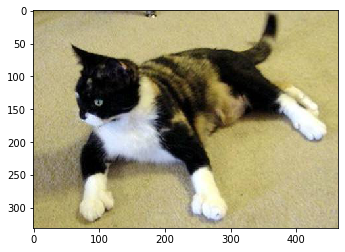

In [5]:
img = Image.open(os.path.join('dogs-vs-cats','train', 'cat.59.jpg'))
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

### Creating Validation and Test Subsets

- Move 2500 images from the training folder into a test set folder
- Move 2500 images from the training folder into a validation set folder

In [6]:
if not os.path.exists(os.path.join('dogs-vs-cats', 'test')):
    os.mkdir(os.path.join('dogs-vs-cats', 'test'))

if not os.path.exists(os.path.join('dogs-vs-cats', 'valid')):
    os.mkdir(os.path.join('dogs-vs-cats', 'valid'))

In [7]:
for fname in os.listdir(os.path.join('dogs-vs-cats', 'train')):
    if not fname.endswith('.jpg'):
        continue
    _, img_num, _ = fname.split('.')
    filepath = os.path.join('dogs-vs-cats', 'train', fname)
    img_num = int(img_num)
    if img_num > 11249:
        os.rename(filepath, filepath.replace('train', 'test'))
    elif img_num > 9999:
        os.rename(filepath, filepath.replace('train', 'valid'))

### Standardizing Images

Getting mean and standard devation for normalizing images via z-score normalization. For details, see the related notebook [./cnn-standardized.ipynb](cnn-standardized.ipynb).

In [8]:
class CatsDogsDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, img_dir, transform=None):
    
        self.img_dir = img_dir
        
        self.img_names = [i for i in 
                          os.listdir(img_dir) 
                          if i.endswith('.jpg')]
        
        self.y = []
        for i in self.img_names:
            if i.split('.')[0] == 'cat':
                self.y.append(0)
            else:
                self.y.append(1)
        
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return len(self.y)

    

custom_transform1 = transforms.Compose([transforms.Resize([64, 64]),
                                        transforms.ToTensor()])

train_dataset = CatsDogsDataset(img_dir=os.path.join('dogs-vs-cats', 'train'), 
                                transform=custom_transform1)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=5000, 
                          shuffle=False)

train_mean = []
train_std = []

for i, image in enumerate(train_loader, 0):
    numpy_image = image[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    train_mean.append(batch_mean)
    train_std.append(batch_std)

train_mean = torch.tensor(np.mean(train_mean, axis=0))
train_std = torch.tensor(np.mean(train_std, axis=0))

print('Mean:', train_mean)
print('Std Dev:', train_std)

Mean: tensor([0.4875, 0.4544, 0.4164])
Std Dev: tensor([0.2521, 0.2453, 0.2481])


### Dataloaders

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(64, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
}


train_dataset = CatsDogsDataset(img_dir=os.path.join('dogs-vs-cats', 'train'), 
                                transform=data_transforms['train'])

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          drop_last=True,
                          shuffle=True)

valid_dataset = CatsDogsDataset(img_dir=os.path.join('dogs-vs-cats', 'valid'), 
                                transform=data_transforms['valid'])

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

test_dataset = CatsDogsDataset(img_dir=os.path.join('dogs-vs-cats', 'test'), 
                               transform=data_transforms['valid'])

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)

## Model

Import VGG16 network from [./vgg16.py](./vgg16.py)

In [10]:
from vgg16 import VGG16

In [11]:
torch.manual_seed(RANDOM_SEED)
model = VGG16(num_classes=NUM_CLASSES)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Training

In [12]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples
    

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader):
    
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} | ' 
                   f'Cost: {cost:.4f}')

            
    model.eval()
    # no need to build the computation graph for backprop when computing accuracy
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/050 | Batch 000/156 | Cost: 1727.7655
Epoch: 001/050 | Batch 050/156 | Cost: 0.6774
Epoch: 001/050 | Batch 100/156 | Cost: 0.7066
Epoch: 001/050 | Batch 150/156 | Cost: 0.6459
Epoch: 001/050 Train Acc.: 59.83% | Validation Acc.: 59.92%
Time elapsed: 3.06 min
Epoch: 002/050 | Batch 000/156 | Cost: 0.6448
Epoch: 002/050 | Batch 050/156 | Cost: 0.6621
Epoch: 002/050 | Batch 100/156 | Cost: 0.6263
Epoch: 002/050 | Batch 150/156 | Cost: 0.6378
Epoch: 002/050 Train Acc.: 59.50% | Validation Acc.: 58.40%
Time elapsed: 6.12 min
Epoch: 003/050 | Batch 000/156 | Cost: 0.6844
Epoch: 003/050 | Batch 050/156 | Cost: 0.6173
Epoch: 003/050 | Batch 100/156 | Cost: 0.6341
Epoch: 003/050 | Batch 150/156 | Cost: 0.7188
Epoch: 003/050 Train Acc.: 56.50% | Validation Acc.: 55.24%
Time elapsed: 9.18 min
Epoch: 004/050 | Batch 000/156 | Cost: 0.7111
Epoch: 004/050 | Batch 050/156 | Cost: 0.5603
Epoch: 004/050 | Batch 100/156 | Cost: 0.5831
Epoch: 004/050 | Batch 150/156 | Cost: 0.6363
Epoch: 004/0

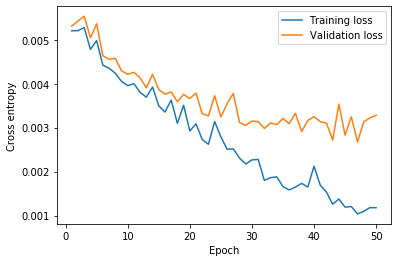

In [13]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

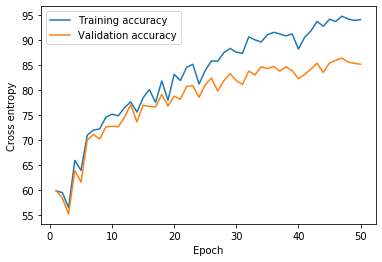

In [14]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

## Evaluation

In [15]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 86.20%


In [16]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
    
unorm = UnNormalize(mean=train_mean, std=train_std)

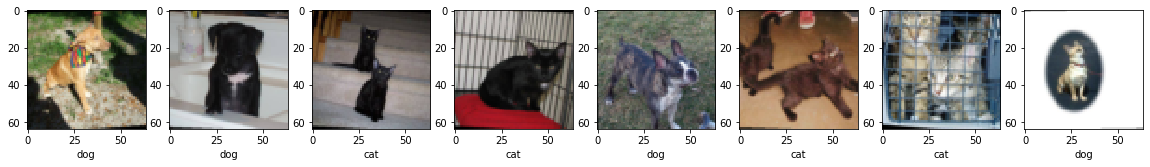

In [17]:
test_loader = DataLoader(dataset=train_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

for features, targets in test_loader:
    break
    

_, predictions = model.forward(features[:8].to(DEVICE))
predictions = torch.argmax(predictions, dim=1)

d = {0: 'cat',
     1: 'dog'}
    
fig, ax = plt.subplots(1, 8, figsize=(20, 10))
for i in range(8):
    img = unorm(features[i])
    ax[i].imshow(np.transpose(img, (1, 2, 0)))
    ax[i].set_xlabel(d[predictions[i].item()])

plt.show()

In [18]:
torch.save(model.state_dict(), 'vgg16-cats-dogs.state_dict')